In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from data import PVDataLoader, PVDataGenerator
from data.utils import train_test_split

In [98]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 3
RADIUS = 0.35
CIRCLE_COORDS = (55, -1.5)
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [99]:
loader = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=CIRCLE_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='circle',
                    drop_nan=False)

X, y = loader.get_time_series()

==> Loading data
==> Loaded data in: 0 m : 18 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [100]:
x_train, y_train, x_test, y_test = train_test_split(X, y, hour=12, minute_interval=MINUTE_INTERVAL, n_hours=N_HOURS_PRED)

In [101]:
y_train.shape

torch.Size([409, 3])

In [146]:
import numpy as np

def create_df(y_train):
    intervals = y_train.size(0) 
    
    unique_ids = np.zeros_like(y_train).flatten()
    unique_ids[::intervals] = 1
    unique_ids = np.cumsum(unique_ids)
    
    y_train = y_train.flatten()
    idx = [i for i in range(intervals)] * int(unique_ids[-1])
    df = pd.DataFrame({'y': y_train, 'unique_id': unique_ids, 'ds': idx})

  

    return df

df_train = create_df(y_train)
df_test = create_df(y_test)

In [163]:
from abc import ABC, abstractmethod
from statsforecast.models import(
    AutoARIMA,
    HoltWinters,
    SeasonalNaive
)

from data.utils import get_hourly_points, get_daily_points

class BaselineForecast(ABC):
    def __init__(self, y_train, day_min, day_max, minute_interval):
        self.y_train = y_train
        self.n_hourly_points = get_hourly_points(day_min, day_max, minute_interval)
        self.daily_points = get_daily_points(day_min, day_max, minute_interval)
    
    @abstractmethod
    def fit(self):
        """ 
        Fit the model
        """
        pass

    @abstractmethod
    def predict(self, n_hours):
        """ 
        Predict n_steps ahead
        """
        pass

class PersistenceForecast(BaselineForecast):
   
    def fit(self):
        pass

    def predict(self, n_hours):
        return self.y_train[-1].repeat(n_hours * self.n_hourly_points)

class YesterdayForecast(BaselineForecast):
    
    def fit(self):
        pass

    def predict(self, n_hours):
        start_idx = self.daily_points
        end_idx = start_idx + self.n_hourly_points * n_hours
        return self.y_train[start_idx:end_idx]

class HourlySmoothing(BaselineForecast):
    def fit(self):
        pass

    def predict(self, n_hours):
        """ 
        Perform hourly smoothing based on the number of points
        per hour. If T is the number of points per hour, and
        K is the minute interval, then the smoothing is performed

        y_{t + \delta t} = 1/T * sum_{i=1}^T y_{t + \delta t - K * i}
            
            where \delta t is the number of hours ahead to predict
        """
        rolling_mean = self.y_train.rolling(1).mean()
        print(rolling_mean)
        



        

In [164]:
persistence = PersistenceForecast(y_train, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
yesterday = YesterdayForecast(y_train, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
hourly = HourlySmoothing(y_train, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)

In [21]:
persistence_pred = persistence.predict(n_hours=2)
yday_pred = yesterday.predict(n_hours=2)


In [22]:
print(persistence_pred.shape, yday_pred.shape)

torch.Size([24]) torch.Size([24])


torch.Size([24])


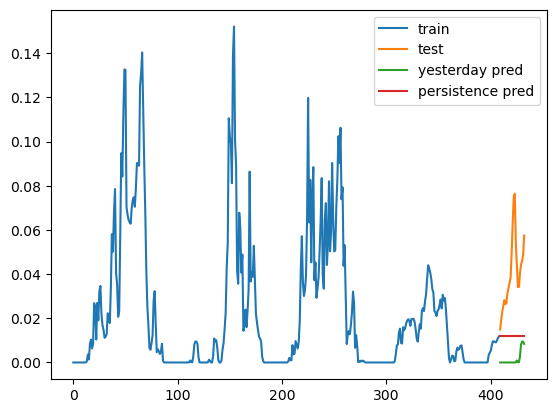

In [24]:
import torch
from matplotlib import pyplot as plt

t = torch.arange(0, len(y))
t_train = t[:len(y_train)]
t_test = t[len(y_train):len(y_train)+len(y_test)]

print(t_test.shape)

plt.plot(t_train, y_train, label='train')
plt.plot(t_test, y_test, label='test')
plt.plot(t_test, yday_pred, label='yesterday pred')
plt.plot(t_test, persistence_pred, label='persistence pred')

plt.legend()